# Developing AI Application
This is an AI application for classifying images using a pretrained neural network classifiaction model. The project is split into three main area:
Load and preprocess the image dataset
Train the image classifier on your dataset
Use the trained classifier to predict image content.

In [67]:
# Imports here
%matplotlib inline
%config InlineBackend.figure.format='retina'

from collections import OrderedDict
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from torch.autograd import variable

from PIL import Image
import torchvision
import matplotlib.pyplot as plt
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
import shutil

# Loading data

In [68]:
data_dir = 'C:/Users/Mitterrand Ekole/Documents/Machine Learning/ML_Dev_Projects_Current/Flower_Image_Classifier/flowers'
train_dir = data_dir + '/train'
valid_dir = data_dir + '/valid'
test_dir = data_dir + '/test'

In [69]:
# TODO: Define your transforms for the training, validation, and testing sets
data_transforms = transforms.Compose(
[
    transforms.RandomRotation(30),
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],
    [0.229,0.224,0.225])
]
)

# TODO: Load the datasets with ImageFolder
image_datasets = datasets.ImageFolder(train_dir, transform=data_transforms)

# TODO: Using the image datasets and the trainforms, define the dataloaders
dataloaders = DataLoader(image_datasets, batch_size=32, shuffle=True)

In [70]:
# Test and validation sets
test_transforms = transforms.Compose([
#    transforms.RandomRotation(30),
#    transforms.RandomResizedCrop(224),
#    transforms.RandomHorizontalFlip(),
    transforms.Resize(255),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], 
                         [0.229, 0.224, 0.225])
])

# TODO: Load the datasets with ImageFolder
valid_dataset = datasets.ImageFolder(valid_dir, transform=test_transforms)
test_dataset = datasets.ImageFolder(test_dir, transform=test_transforms)

# TODO: Using the image datasets and the trainforms, define the dataloaders
validloader = DataLoader(valid_dataset, batch_size=32, shuffle=False)
testloader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [71]:
def imshow(image, ax=None, title=None):
    """Imshow for Tensor."""
    if ax is None:
        fig, ax = plt.subplots()
    
    # PyTorch tensors assume the color channel is the first dimension
    # but matplotlib assumes is the third dimension
    image = image.numpy().transpose((1, 2, 0))
    
    # Undo preprocessing
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean
    
    # Image needs to be clipped between 0 and 1 or it looks like noise when displayed
    image = np.clip(image, 0, 1)
    
    ax.imshow(image)
    
    return ax

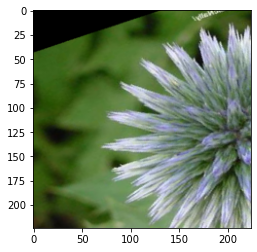

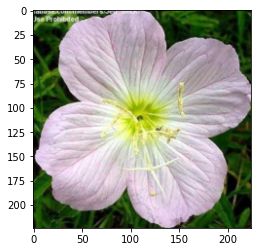

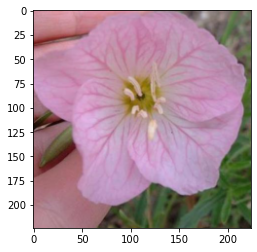

In [72]:
images, labels = next(iter(dataloaders))
imshow(images[2])

images, labels = next(iter(validloader))
imshow(images[2])

images, labels = next(iter(testloader))
imshow(images[2])

In [73]:
#Label mapping

import json

with open('cat_to_name.json', 'r') as f:
    cat_to_name = json.load(f)

In [75]:
# Building  and training  the neural network
model = models.densenet121(pretrained=True)

In [76]:
#Freeze feature parameters

for params in model.parameters():
    params.requires_grad=False

In [77]:
classifier= nn.Sequential(OrderedDict([
    ('fc1', nn.Linear(1024, 200)),
    ('relu', nn.ReLU()), 
    ('fc2', nn.Linear(200, 102)),
    ('drop', nn.Dropout(p=0.5)),
    ('output', nn.LogSoftmax(dim=1))
]))

In [78]:
model.classifier=classifier

In [79]:
def save_checkpoint(state, is_best=False, filename='checkpoint.pth.tar'):
    torch.save(state, filename)
    if is_best:
        shutil.copyfile(filename, 'model_best.pth.tar')

In [80]:
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.classifier.parameters(), lr=0.001)

cuda = torch.cuda.is_available()

if cuda:
    model.cuda()
else:
    model.cpu()
    
epochs = 3
print_every = 5
save_every = 50
steps = 0

for e in range(epochs):
    model.train()
    running_loss = 0
    accuracy_train = 0
    
    for images, labels in iter(dataloaders):
        steps += 1
        
        inputs, labels = variable(images), variable(labels)
        
        optimizer.zero_grad()
        
        if cuda:
            inputs, labels = inputs.cuda(), labels.cuda()
        
        output = model.forward(inputs)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        ps_train = torch.exp(output).data
        equality_train = (labels.data == ps_train.max(1)[1])
        accuracy_train += equality_train.type_as(torch.FloatTensor()).mean()
        
        
        
        if steps % print_every == 0:
            model.eval()
            
            accuracy = 0
            valid_loss = 0
            
            for images, labels in validloader:
                with torch.no_grad():
                    inputs = variable(images)
                    labels = variable(labels)

                    if cuda:
                        inputs, labels = inputs.cuda(), labels.cuda()

                    output = model.forward(inputs)

                    valid_loss += criterion(output, labels).item()

                    ps = torch.exp(output).data
                    equality = (labels.data == ps.max(1)[1])

                    accuracy += equality.type_as(torch.FloatTensor()).mean()
                
            print("Epoch: {}/{}.. ".format(e+1, epochs), 
                  "Training Loss: {:.3f}.. ".format(running_loss/print_every),
                  "Validation Loss: {:.3f}..".format(valid_loss/len(validloader)),
                  "Training Accuracy: {:.3f}".format(accuracy_train/len(dataloaders)),
                  "Validation Accuracy: {:.3f}".format(accuracy/len(validloader)))
            
            running_loss = 0
            model.train()
            
        if steps % save_every == 0:
            print("Saving step number {}...".format(steps))
            state = {'state_dict': model.classifier.state_dict(),
                     'optimizer' : optimizer.state_dict(),
                     'class_to_idx':train_dataset.class_to_idx}
            
            save_checkpoint(state)
            print("Done!")
            

                


KeyboardInterrupt: 

In [81]:
#Testing the network

cuda= False

In [82]:
# TODO: Do validation on the test set
model.eval()
criterion = nn.NLLLoss()


if cuda:
    model.cuda()
else:
    model.cpu()
    
accuracy = 0
test_loss = 0

for images, labels in testloader:
    with torch.no_grad():
        inputs = variable(images)
        labels = variable(labels)

        if cuda:
            inputs, labels = inputs.cuda(), labels.cuda()

        output = model.forward(inputs)

        test_loss += criterion(output, labels).item()

        ps = torch.exp(output).data
        equality = (labels.data == ps.max(1)[1])

        accuracy += equality.type_as(torch.FloatTensor()).mean()

print("Test Loss: {:.3f}..".format(test_loss/len(testloader)),
      "Test Accuracy: {:.3f}".format(accuracy/len(testloader)))


KeyboardInterrupt: 

In [83]:
#Saving Checkpoint

class_to_idx = image_datasets.class_to_idx
model.class_to_idx = class_to_idx
model.idx_to_class = inv_map = {v: k for k, v in class_to_idx.items()}

In [84]:
def save_checkpoint(state, is_best=False, filename='checkpoint.pth.tar'):
    torch.save(state, filename)
    if is_best:
        shutil.copyfile(filename, 'model_best.pth.tar')

In [85]:
# TODO: Save the checkpoint 
state = {#'input_size': 784,
         'output_size': 102,
         'state_dict': model.classifier.state_dict(),
         'optimizer' : optimizer.state_dict(),
         'class_to_idx':image_datasets.class_to_idx
}


In [86]:
save_checkpoint(state)

In [87]:
ls

 Volume in drive C is Ekole
 Volume Serial Number is A0BD-C79F

 Directory of C:\Users\Mitterrand Ekole\Documents\Machine Learning\ML_Dev_Projects_Current\Flower_Image_Classifier

12/30/2020  08:42 PM    <DIR>          .
12/30/2020  08:42 PM    <DIR>          ..
12/30/2020  04:50 AM    <DIR>          .git
02/06/2018  10:25 PM             1,157 .gitignore
12/30/2020  08:18 PM    <DIR>          .ipynb_checkpoints
12/30/2020  04:50 AM    <DIR>          .vscode
12/30/2020  04:50 AM    <DIR>          assets
02/06/2018  11:35 PM             2,218 cat_to_name.json
12/30/2020  08:43 PM         2,711,247 checkpoint.pth.tar
12/30/2020  08:42 PM           524,596 Flower_Image_Classifier.ipynb
12/30/2020  04:52 AM    <DIR>          flowers
02/06/2018  10:25 PM             1,064 LICENSE
12/22/2020  02:58 AM             4,238 predict.py
04/20/2018  06:28 AM               250 README.md
12/26/2020  12:09 PM             8,715 train.py
09/28/2018  10:25 PM             1,540 workspace-utils.py
          

In [88]:
#   loading a checkpoint and rebuilds the model
local_machine=True

def load_checkpoint(filepath):
    if local_machine:
        checkpoint = torch.load(filepath, map_location='cpu')
    else:
        checkpoint = torch.load(filepath)
    model = models.densenet121(pretrained=True)
    
    # Freeze the feature parameters
    for params in model.parameters():
        params.requires_grad = False
    
    classifier = nn.Sequential(OrderedDict([
        ('fc1', nn.Linear(1024, 200)),
        ('relu', nn.ReLU()), 
        ('fc2', nn.Linear(200, 102)),
        ('drop', nn.Dropout(p=0.5)),
        ('output', nn.LogSoftmax(dim=1))
    ]))

    classifier.load_state_dict(checkpoint['state_dict'])
    
    
    model.classifier = classifier
    class_to_idx = checkpoint['class_to_idx']
    model.class_to_idx = class_to_idx
    model.idx_to_class = inv_map = {v: k for k, v in class_to_idx.items()}
    
    return model

In [89]:
model= load_checkpoint("checkpoint.pth.tar")

In [90]:
#Image: processing PIL image to work with pytorch model

def process_image(image):
    
    img_transforms = transforms.Compose([
            transforms.Resize(255),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], 
                         [0.229, 0.224, 0.225])
        ])
    
    image = img_transforms(Image.open(image))
    
    return image

    
 

In [91]:
def show_image(image, mx=None, title=None):
    """Imshow for Tensor."""
    if mx is None:
        fig, mx = plt.subplots()
    
  
    image = image.numpy().transpose((1, 2, 0))
    
   
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean
    
   
    image = np.clip(image, 0, 1)
    
    mx.imshow(image)
    
    return mx

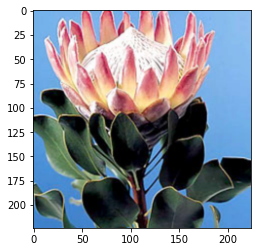

In [92]:
img= process_image('flowers/test/13/image_05787.jpg')
show_image(img)

In [93]:
#Class prediction using top k classess

path= 'flowers/test/2/image_05100.jpg'

In [94]:
#Function to predict class from image file

def predict(image_path, model, topk=5):
    ''' Predict the class (or classes) of an image using a trained deep learning model.
    '''
    image_data = process_image(image_path)
    if cuda:
        model.cuda()
    else:
        model.cpu()
        
    model_p = model.eval()
    
    inputs = variable(image_data.unsqueeze(0))
    #labels = variable(labels)

    if cuda:
        inputs = inputs.cuda(), #labels.cuda()
    
    output = model_p(inputs)
    ps = torch.exp(output).data
    
    ps_top = ps.topk(topk)
    idx2class = model.idx_to_class
    probs = ps_top[0].tolist()[0]
    classes = [idx2class[i] for i in ps_top[1].tolist()[0]]
    
    return probs, classes


In [95]:
probs, classes = predict(path, model)

print(probs)
print(classes)

[0.017924584448337555, 0.016569744795560837, 0.015022310428321362, 0.01471973117440939, 0.014529543928802013]
['21', '67', '102', '74', '3']


In [96]:
path = 'flowers/test/1/image_06743.jpg'

probs, classes = predict(path, model)

print(probs)
print(classes)

[0.015083126723766327, 0.015004463493824005, 0.014740662649273872, 0.014544523321092129, 0.014423205517232418]
['67', '83', '102', '74', '50']


In [106]:
#  Displaying an image along with the top 5 classes to verify if model works
path = 'flowers/test/13/image_05745.jpg'
path

'flowers/test/13/image_05745.jpg'

In [107]:
#cat_to_name= 'cat_to_name.json'
def plot_probas(path, model, cat_to_name):
    fig, (ax1, ax2) = plt.subplots(figsize=(6, 7), nrows=2)
    ax1.axis('off')
    probs, classes = predict(path, model)
    class_names = [cat_to_name[i] for i in classes]
    ax2.barh(class_names, probs)
    imshow(process_image(path), ax=ax1)


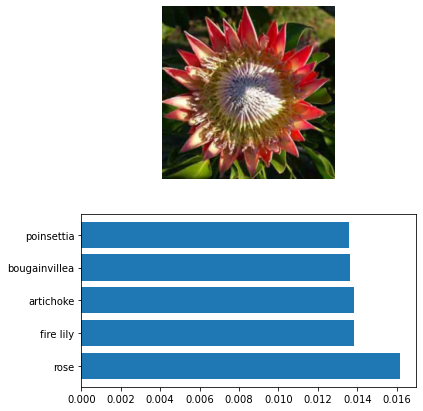

In [108]:

plot_probas(path, model, cat_to_name)